#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [ ]:
oil_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       825 non-null    datetime64[ns]
 1   WTI_Price  795 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.0 KB


In [ ]:
oil_price.head()

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57558 entries, 0 to 57557
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           57558 non-null  datetime64[ns]
 1   Store_ID       57558 non-null  int64         
 2   CustomerCount  57558 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.3 MB


In [ ]:
orders.head()

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934275 entries, 0 to 934274
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        934275 non-null  datetime64[ns]
 1   Store_ID    934275 non-null  int64         
 2   Qty         934275 non-null  float64       
 3   Product_ID  934275 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 28.5 MB


In [ ]:
sales.head()

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product_ID    16 non-null     int64 
 1   Product_Code  16 non-null     object
 2   SubCategory   16 non-null     object
 3   Category      16 non-null     object
 4   LeadTime      16 non-null     int64 
 5   Price         16 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 896.0+ bytes


In [ ]:
products.head()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34


In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Store_ID    54 non-null     int64 
 1   City        54 non-null     object
 2   State       54 non-null     object
 3   Store_Type  54 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.8+ KB


In [ ]:
stores.head()

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
store44_3_df = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 3)]
store44_12_df = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 12)]
store44_42_df = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 42)]

In [ ]:
# 날짜를 인덱스로 설정
store44_3_df.set_index('Date', inplace=True)
store44_12_df.set_index('Date', inplace=True)
store44_42_df.set_index('Date', inplace=True)

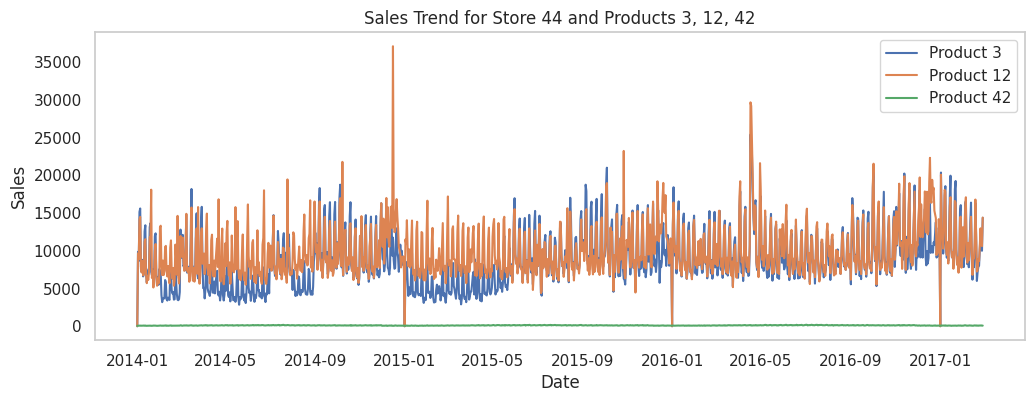

In [ ]:
import matplotlib.pyplot as plt

# 시계열 패턴 시각화
plt.figure(figsize=(12, 4))
plt.plot(store44_3_df['Qty'], label='Product 3')
plt.plot(store44_12_df['Qty'], label='Product 12')
plt.plot(store44_42_df['Qty'], label='Product 42')

plt.title('Sales Trend for Store 44 and Products 3, 12, 42')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [ ]:
products_sales_df = pd.merge(products, sales, on='Product_ID')

products3_df = products_sales_df[products_sales_df['Category'] == 'Drink']
products12_df = products_sales_df[products_sales_df['Category'] == 'Food']
products42_df = products_sales_df[products_sales_df['Category'] == 'Grocery']

In [ ]:
# 날짜를 인덱스로 설정
products3_df.set_index('Date', inplace=True)
products12_df.set_index('Date', inplace=True)
products42_df.set_index('Date', inplace=True)

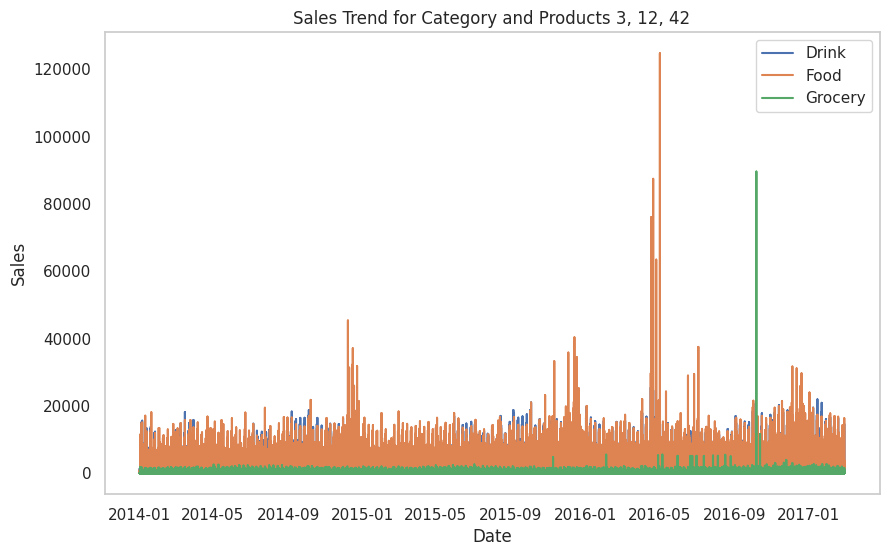

In [ ]:
import matplotlib.pyplot as plt

# 시계열 패턴 시각화
plt.figure(figsize=(10, 6))
plt.plot(products3_df['Qty'], label='Drink')
plt.plot(products12_df['Qty'], label='Food')
plt.plot(products42_df['Qty'], label='Grocery')

plt.title('Sales Trend for Category and Products 3, 12, 42')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

### 3) 휘발류 가격과 상품 판매량 추이 비교

In [ ]:
df_drink = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==3)]
df_drink = pd.merge(df_drink, oil_price, how='left')
df_drink = pd.merge(df_drink, orders[orders['Store_ID']==44], how = 'left')

In [ ]:
df_food = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==12)]
df_food = pd.merge(df_food, oil_price, how='left')
df_food = pd.merge(df_food, orders[orders['Store_ID']==44], how = 'left')

In [ ]:
df_gro = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==42)]
df_gro = pd.merge(df_gro, oil_price, how='left')
df_gro = pd.merge(df_gro, orders[orders['Store_ID']==44], how = 'left')

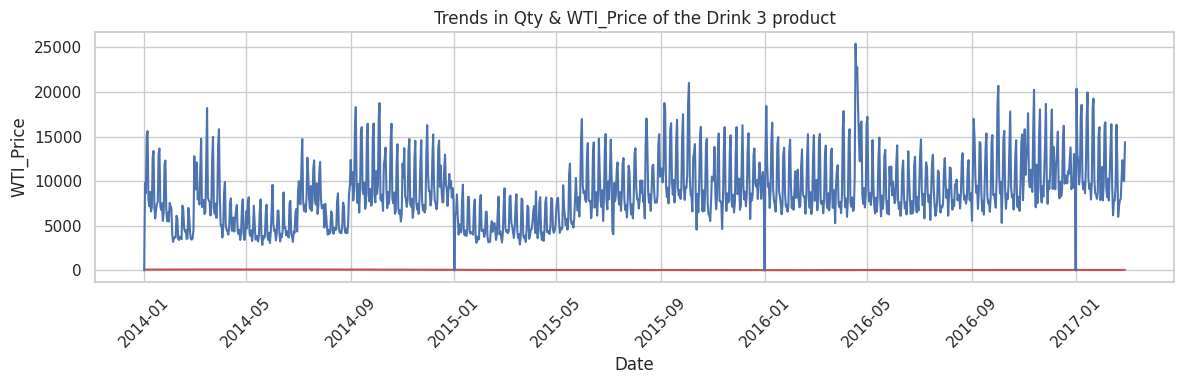

In [ ]:
# 그래프 스타일 설정
sns.set(style="whitegrid")

# 그래프 그리기
plt.figure(figsize=(12,4))
sns.lineplot(x='Date', y='WTI_Price', data=df_drink, color='r', linestyle='-')
sns.lineplot(x='Date', y='Qty', data=df_drink, color='b', linestyle='-')

# 그래프 제목 및 축 레이블 설정
plt.title('Trends in Qty & WTI_Price of the Drink 3 product')
plt.xlabel('Date')
plt.ylabel('WTI_Price')

# x 축 눈금 라벨 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()

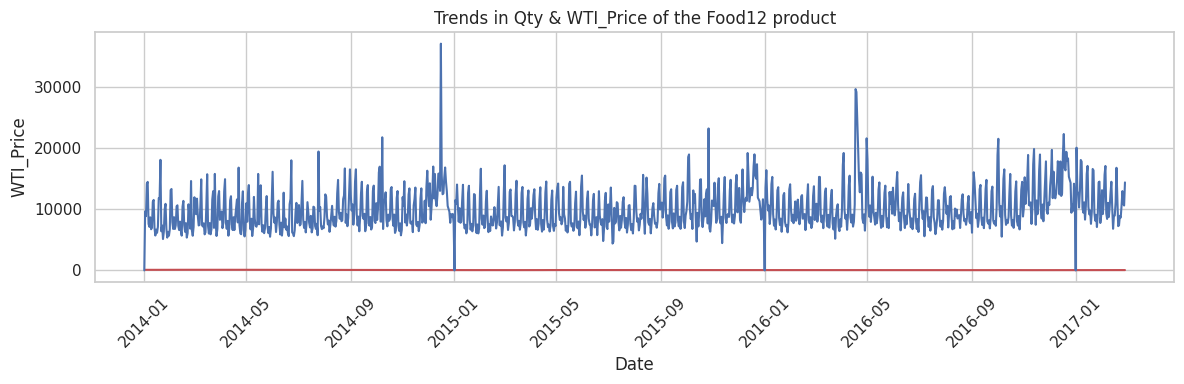

In [ ]:
# 그래프 스타일 설정
sns.set(style="whitegrid")

# 그래프 그리기
plt.figure(figsize=(12,4))
sns.lineplot(x='Date', y='WTI_Price', data=df_food, color='r', linestyle='-')
sns.lineplot(x='Date', y='Qty', data=df_food, color='b', linestyle='-')

# 그래프 제목 및 축 레이블 설정
plt.title('Trends in Qty & WTI_Price of the Food12 product')
plt.xlabel('Date')
plt.ylabel('WTI_Price')

# x 축 눈금 라벨 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()

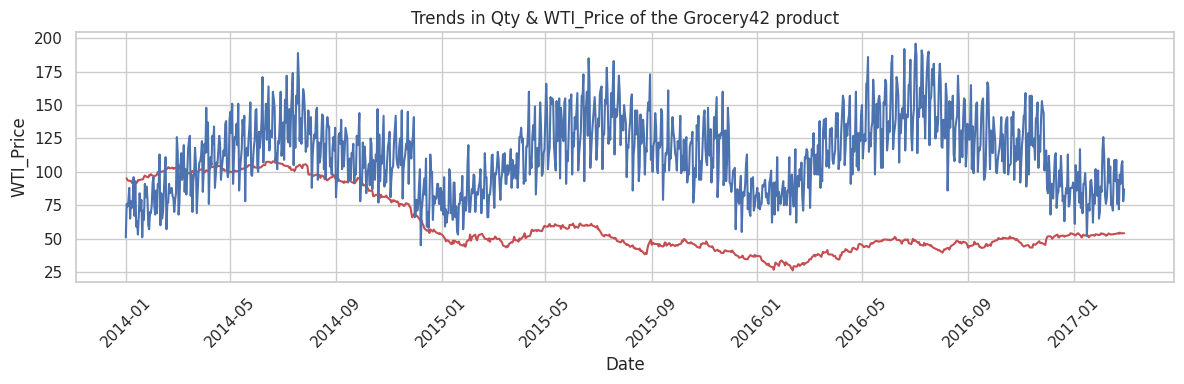

In [ ]:
# 그래프 스타일 설정
sns.set(style="whitegrid")

# 그래프 그리기
plt.figure(figsize=(12,4))
sns.lineplot(x='Date', y='WTI_Price', data=df_gro, color='r', linestyle='-')
sns.lineplot(x='Date', y='Qty', data=df_gro, color='b', linestyle='-')

# 그래프 제목 및 축 레이블 설정
plt.title('Trends in Qty & WTI_Price of the Grocery42 product')
plt.xlabel('Date')
plt.ylabel('WTI_Price')

# x 축 눈금 라벨 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()

### 4) 방문 고객수와 상품 판매량 추이 비교

In [ ]:
stores_44 = orders[orders['Store_ID']==44]
customers_44 = orders[orders['Store_ID']==44].groupby('Date')['CustomerCount'].sum()

In [ ]:
df_44_3 = sales[(sales['Store_ID']==44) & (sales['Product_ID']==3)]
df_44_3 = df_44_3.groupby('Date')['Qty'].sum()

df_44_12 = sales[(sales['Store_ID']==44) & (sales['Product_ID']==12)]
df_44_12 = df_44_12.groupby('Date')['Qty'].sum()

df_44_42 = sales[(sales['Store_ID']==44) & (sales['Product_ID']==42)]
df_44_42 = df_44_42.groupby('Date')['Qty'].sum()

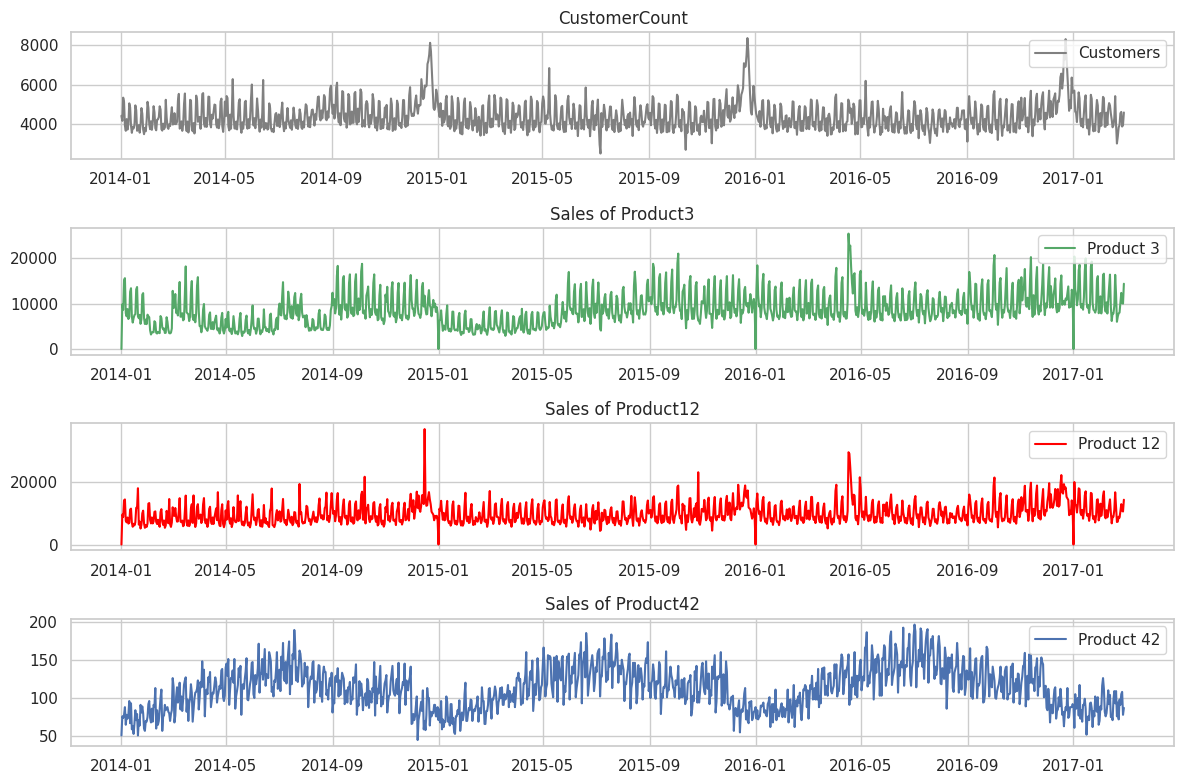

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(4,1,1)
plt.plot(customers_44, label='Customers', color='gray')
plt.title("CustomerCount")
plt.legend(loc='upper right')

plt.subplot(4,1,2)
plt.plot(df_44_3, label='Product 3', color = 'g')
plt.title("Sales of Product3")
plt.legend(loc='upper right')

plt.subplot(4,1,3)
plt.plot(df_44_12, label='Product 12', color = 'red')
plt.title("Sales of Product12")
plt.legend()

plt.subplot(4,1,4)
plt.plot(df_44_42, label='Product 42', color = 'b')
plt.title("Sales of Product42")
plt.legend()

plt.tight_layout()
plt.show()

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
df_drink['Qty_diff'] = df_drink['Qty'].diff()
df_drink['Qty_diff_abs']  = abs(df_drink['Qty_diff'])

df_food['Qty_diff'] = df_food['Qty'].diff()
df_food['Qty_diff_abs']  = abs(df_food['Qty_diff'])

df_gro['Qty_diff'] = df_gro['Qty'].diff()
df_gro['Qty_diff_abs']  = abs(df_gro['Qty_diff'])

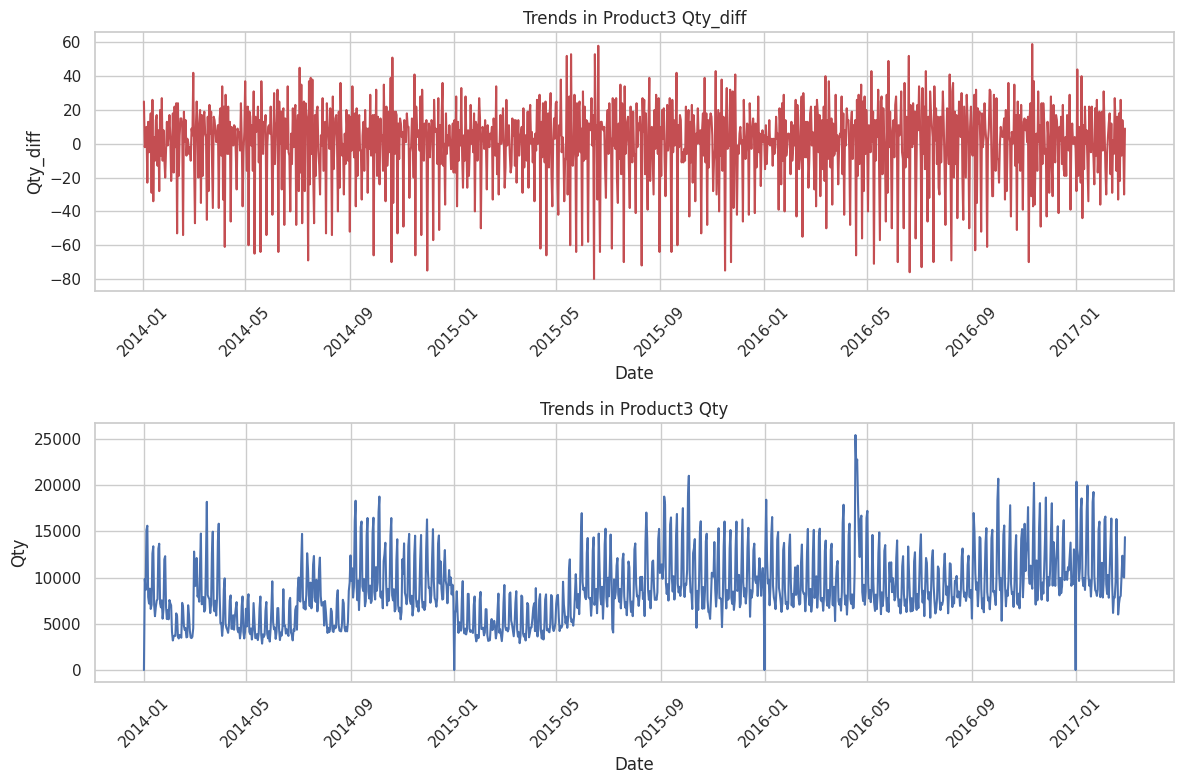

In [ ]:
# 서브플롯 설정
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 첫 번째 서브플롯: CustomerCount 그래프
sns.lineplot(x='Date', y='Qty_diff', data=df_gro, color='r', linestyle='-', ax=ax1)
ax1.set_title('Trends in Product3 Qty_diff')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty_diff')
ax1.tick_params(axis='x', rotation=45)

# 두 번째 서브플롯: Qty 그래프
sns.lineplot(x='Date', y='Qty', data=df_drink, color='b', linestyle='-', ax=ax2)
ax2.set_title('Trends in Product3 Qty')
ax2.set_xlabel('Date')
ax2.set_ylabel('Qty')
ax2.tick_params(axis='x', rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()

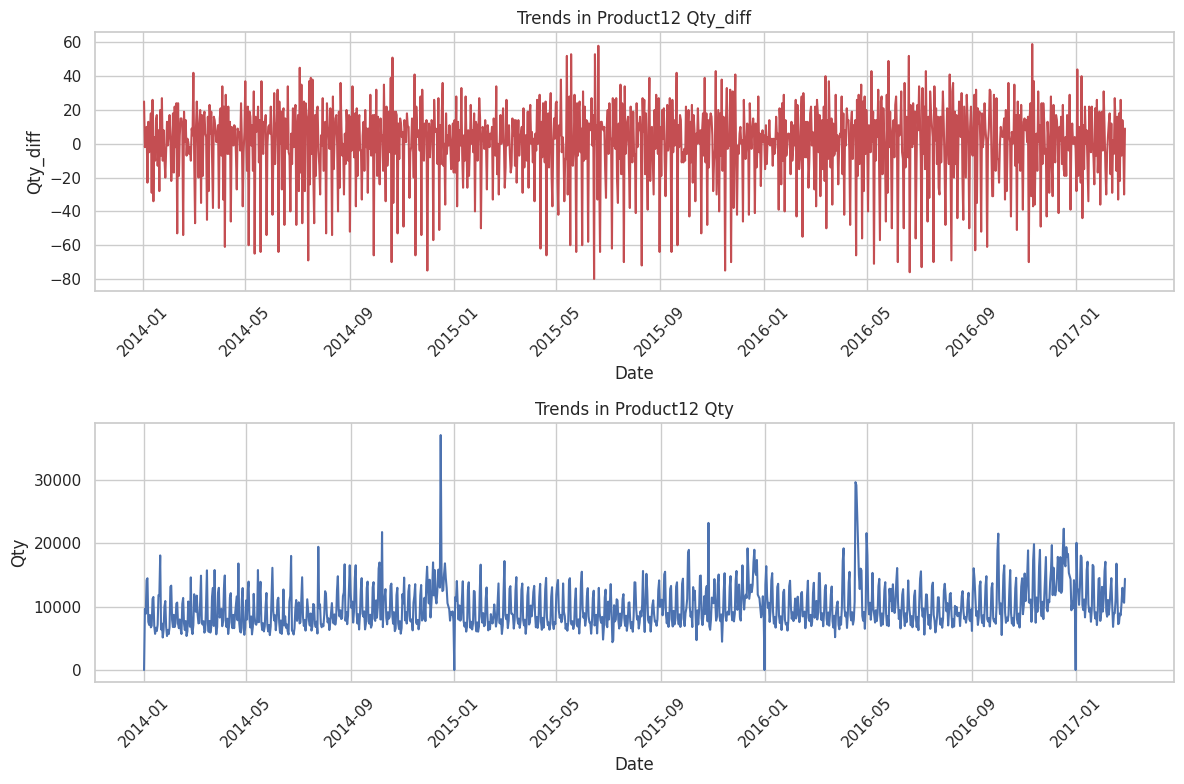

In [ ]:
# 서브플롯 설정
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 첫 번째 서브플롯: CustomerCount 그래프
sns.lineplot(x='Date', y='Qty_diff', data=df_gro, color='r', linestyle='-', ax=ax1)
ax1.set_title('Trends in Product12 Qty_diff')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty_diff')
ax1.tick_params(axis='x', rotation=45)

# 두 번째 서브플롯: Qty 그래프
sns.lineplot(x='Date', y='Qty', data=df_food, color='b', linestyle='-', ax=ax2)
ax2.set_title('Trends in Product12 Qty')
ax2.set_xlabel('Date')
ax2.set_ylabel('Qty')
ax2.tick_params(axis='x', rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()

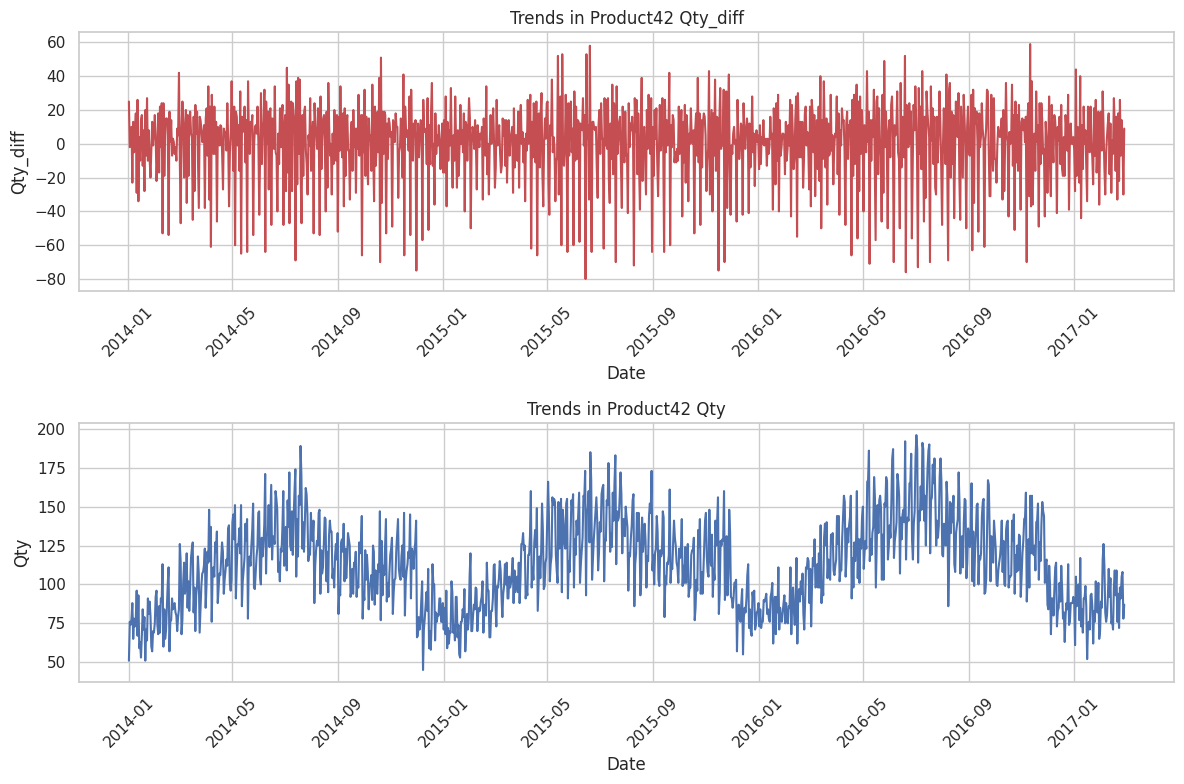

In [ ]:
# 서브플롯 설정
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 첫 번째 서브플롯: CustomerCount 그래프
sns.lineplot(x='Date', y='Qty_diff', data=df_gro, color='r', linestyle='-', ax=ax1)
ax1.set_title('Trends in Product42 Qty_diff')
ax1.set_xlabel('Date')
ax1.set_ylabel('Qty_diff')
ax1.tick_params(axis='x', rotation=45)

# 두 번째 서브플롯: Qty 그래프
sns.lineplot(x='Date', y='Qty', data=df_gro, color='b', linestyle='-', ax=ax2)
ax2.set_title('Trends in Product42 Qty')
ax2.set_xlabel('Date')
ax2.set_ylabel('Qty')
ax2.tick_params(axis='x', rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()

### 2) 요일별 변화량 비교

In [ ]:
sales['Weekday'] = sales['Date'].dt.weekday

df_weekday = sales.groupby(['Weekday','Product_ID'])['Qty'].sum()
df_weekday = df_weekday.reset_index()

In [ ]:
df_weekday

,Weekday,Product_ID,Qty
0,0,3,2.249636e+07
1,0,5,4.284758e+06
2,0,7,9.684020e+06
3,0,8,6.707780e+06
4,0,10,1.833010e+06
...,...,...,...
107,6,27,8.989700e+04
108,6,29,1.099895e+06
109,6,32,2.605323e+05
110,6,38,2.010430e+05


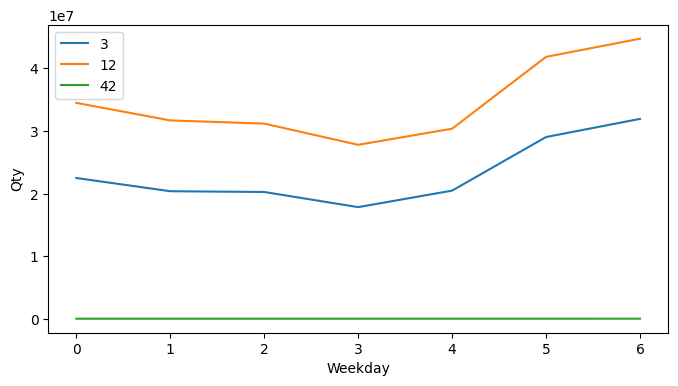

In [ ]:
plt.figure(figsize=(8,4))

temp = df_weekday[df_weekday['Product_ID']==3]
plt.plot(temp['Weekday'], temp['Qty'], label='3')

temp = df_weekday[df_weekday['Product_ID']==12]
plt.plot(temp['Weekday'], temp['Qty'], label='12')

temp = df_weekday[df_weekday['Product_ID']==42]
plt.plot(temp['Weekday'], temp['Qty'], label='42')

plt.xlabel('Weekday')
plt.ylabel('Qty')
plt.legend()
plt.show()

### 3) 시계열 데이터 분해

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

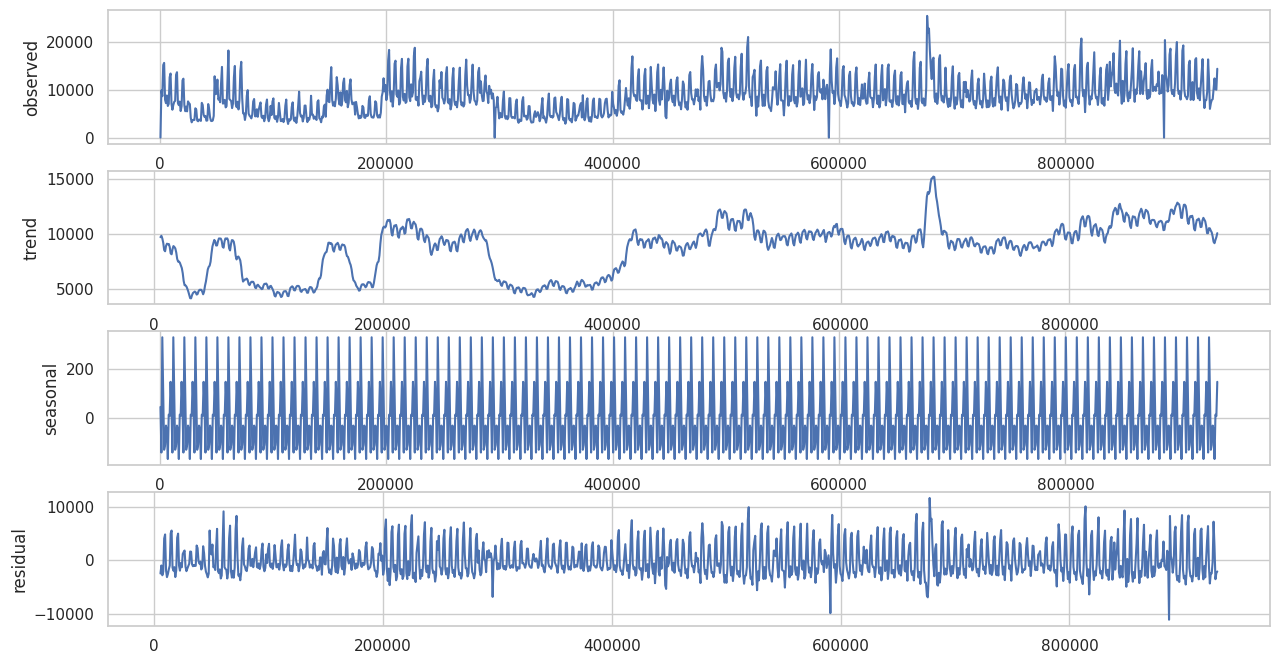

,observed,trend,seasonal,residual
645,0.0,NaN,44.768056,NaN
1456,9853.0,NaN,-142.055629,NaN
2267,8647.0,NaN,330.276389,NaN
3078,15153.0,NaN,90.716740,NaN
3889,15606.0,NaN,-130.749927,NaN
...,...,...,...,...
930865,10208.0,NaN,-49.544225,NaN
931676,12361.0,NaN,-168.697734,NaN
932487,10108.0,NaN,13.086915,NaN
933298,10006.0,NaN,7.333406,NaN


In [ ]:
decomp_plot(3, '2014-01-01', '2017-02-28', 12)

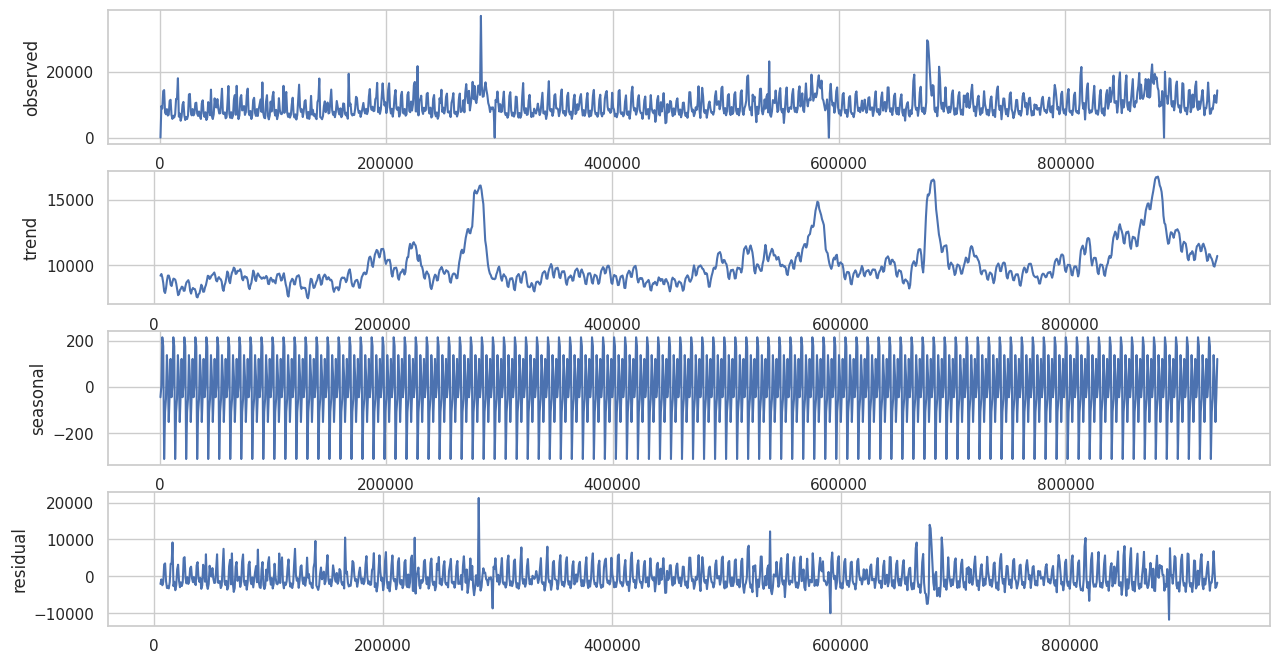

,observed,trend,seasonal,residual
651,0.0,NaN,-44.274332,NaN
1462,9647.0,NaN,4.421861,NaN
2273,8879.0,NaN,214.286370,NaN
3084,14188.0,NaN,175.622335,NaN
3895,14490.0,NaN,-310.846525,NaN
...,...,...,...,...
930871,10630.0,NaN,137.391195,NaN
931682,12978.0,NaN,44.131546,NaN
932493,10899.0,NaN,-151.191261,NaN
933304,10618.0,NaN,-32.584461,NaN


In [ ]:
decomp_plot(12, '2014-01-01', '2017-02-28', 12)

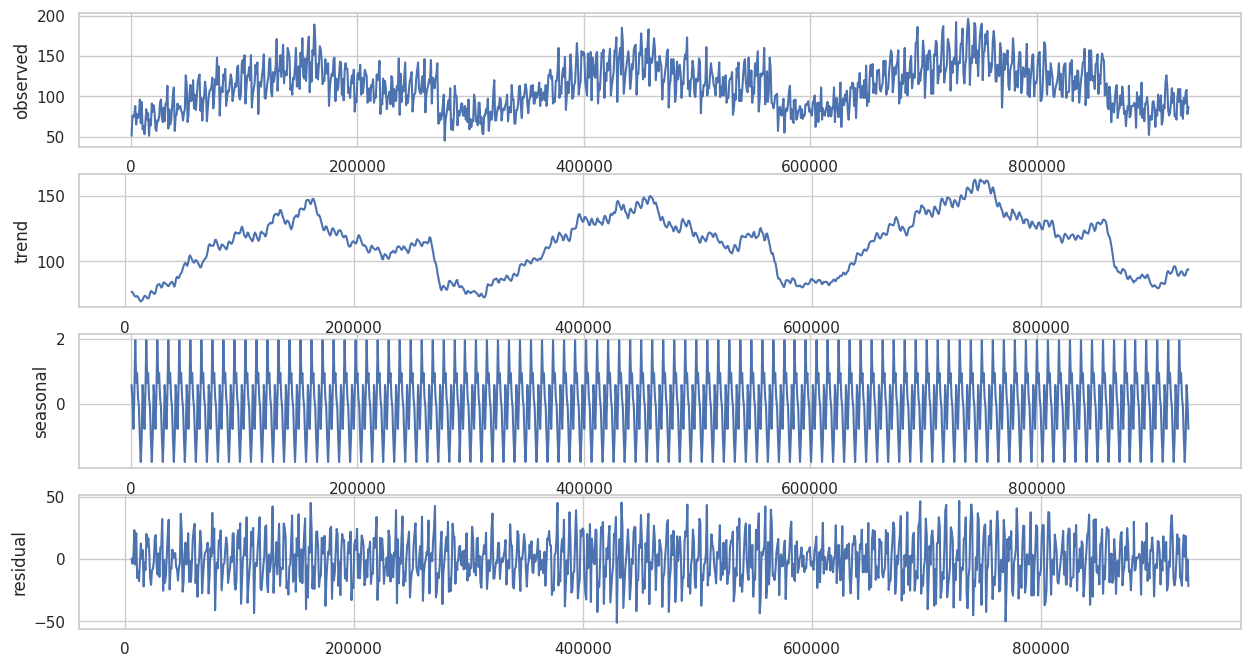

,observed,trend,seasonal,residual
658,51.0,NaN,0.583969,NaN
1469,76.0,NaN,0.091425,NaN
2280,74.0,NaN,-0.767785,NaN
3091,78.0,NaN,0.286601,NaN
3902,88.0,NaN,1.959408,NaN
...,...,...,...,...
930878,91.0,NaN,-1.786645,NaN
931689,105.0,NaN,-1.029189,NaN
932500,108.0,NaN,0.583969,NaN
933311,78.0,NaN,0.091425,NaN


In [ ]:
decomp_plot(42, '2014-01-01', '2017-02-28', 12)

### 4) 그 외 패턴 찾아보기

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

### [제품3]
* 여름에 판매량이 증가하고 겨울에 감소하는 계절성을 보임
* 겨울보다는 여름에 음료수를 더 많이 마시지 않을까 추측
* 계절성과 추세를 제외한 후에도 설명되지 않는 변동성이 존재
이는 임의적이거나 예측 불가능한 요인(예: 일시적인 프로모션, 경쟁사 활동, 외부 이벤트 등)에 의해 영향을 받을 수 있음

### [제품12]
- 상품 정보:
    - 상품 12의 Product_Code는 GA001.
    - 상품 12의 카테고리는 Food이며, 하위 카테고리는 Milk.
    - 상품 12의 리드타임(LeadTime)은 3일이며, 가격(Price)은 6.
- 판매량 추이:
    - 매장 44에서 상품 12의 판매량은 시간에 따라 변동이 있다.
    - 같은 카테고리(Food)의 다른 상품들과 비교했을 때, 상품 12의 판매량 추이는 유사한 패턴을 보인다.
- 휘발유 가격과의 관계:
    - 상품 12의 판매량은 휘발유 가격과 대체로 반비례 관계를 보인다.
    - 휘발유 가격이 상승할 때 상품 12의 판매량은 감소하는 경향이 있고, 휘발유 가격이 하락할 때는 판매량이 증가하는 모습을 보인다.
    - 이는 휘발유 가격 변동이 소비자의 구매력에 영향을 미쳐, 상품 12의 판매량에 영향을 준 것으로 해석된다.
- 방문 고객 수와의 관계:
    - 상품 12의 판매량 추이와 매장 44의 방문 고객 수 추이를 비교해보면, 대체로 양의 상관관계를 보입니다.
    - 방문 고객 수가 증가할 때 상품 12의 판매량도 증가하는 경향이 있다.
- 시계열 분해 결과:
    - 상품 12의 판매량 데이터를 시계열 분해한 결과, 뚜렷한 추세(trend)와 계절성(seasonal)이 확인된다.
    - 잔차(residual)는 추세와 계절성을 제외한 불규칙적인 요인을 나타내며, 이는 모델의 성능을 평가하는 데 활용될 수 있다.

### [제품42]
* 여름에 판매량이 많음
* 농수산물 가격과 유가의 가격이 같이 오르내리는 것을 확인할 수 있었음
* 제품별 판매수량(Qty)을 관찰했을때, 농산물의 경우 판매수량이 최소 45이상 (0이 없음).
    * 즉, 곡물, 채소류, 과일류 등 농산물은 꾸준한 수요량과 판매량이 확보된다고 사료됨.
* 농산물에 판매수량은 다른 식료품(달걀,고기,해산물)과 다르게 40~200 사이의 패턴을 가지고 있음.
    * 여름에 판매수량이 가장 높고, 겨울에 판매수량이 가장 낮음

### [총합]
* 제품 3, 12는 여름에 판매량이 증가하고 겨울에 감소하는 계절성을 보임
    * 여름 음료나 겨울 음료처럼 계절에 따라 수요가 크게 변하는 제품
    * 계절성과 추세를 제외한 후에도 설명되지 않는 변동성이 존재
        * 이는 임의적이거나 예측 불가능한 요인(예: 일시적인 프로모션, 경쟁사 활동, 외부 이벤트 등)에 의해 영향을 받을 수 있음

* 제품 3, 12의 판매량은 유가 변동과 상관관계가 있어 보임
    * 운송 비용: 유가가 상승하면 음료나 물을 포함한 제품의 운송 비용이 증가. 이는 제조사나 유통업체의 비용 증가로 이어질 수 있으며, 최종적으로 소비자 가격에 반영될 수 있음.
    * 포장재 비용: 많은 음료와 생수는 플라스틱 병이나 캔 등의 석유 화학 제품으로 만들어진 포장재를 사용. 유가 상승은 이러한 포장재의 원료 가격을 상승시킬 수 있으며, 이는 음료 및 생수 제조사의 비용 증가로 이어질 수 있음.
    * 에너지 비용: 음료 및 생수 제조 과정에서 사용되는 기계 및 설비는 주로 전기나 화석 연료를 사용. 유가 상승은 에너지 비용 증가로 이어질 수 있으며, 이는 제조 비용 증가의 원인이 될 수 있음.
    * 소비자 구매력: 유가 상승으로 인해 소비자의 가처분 소득이 감소할 경우, 음료나 생수와 같은 비필수적인 소비재에 대한 수요가 감소. 이는 음료 및 생수 제조사의 매출에 부정적인 영향을 미칠 수 있음.
* 제품 42는 뚜렷한 Trend나 계절성 없이 랜덤한 변동성을 보임
    * 제품의 판매량은 장기적인 추세. 시간이 지남에 따라 일관되게 증가 또는 감소하는 패턴
    * 외부 요인이나 계절적 변동에 크게 영향을 받지 않는 안정적인 수요를 가진 제품
* 방문 고객 수와 모든 제품의 판매량은 양의 상관관계를 보임
